In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
print("torch-scatter installed")
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
print("torch-sparse installed")
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
print("torch-geometric installed")



2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 38.6 MB/s eta 0:00:00
torch-scatter installed
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 76.8 MB/s eta 0:00:00
torch-sparse installed
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
torch-geometric installed


In [ ]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
import torch.nn.functional as F

# Load the Cora dataset
dataset = Planetoid(root='./data', name='Cora')
data = dataset[0]

# Convert node features to torch tensor
data.x = data.x.float()

# Initialize the masks
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

# Split data into training, validation, and test sets
data.train_mask[:200] = True  # Select the first 200 nodes for training
data.val_mask[200:500] = True  # Select nodes 200 to 500 for validation
data.test_mask[500:] = True  # Select the rest for testing


Processing...
Done!


In [6]:
from torch_geometric.datasets import Planetoid

# Download the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora')

In [8]:
import shutil

# Zip the Cora dataset directory
shutil.make_archive('/content/data/Cora', 'zip', '/content/data/Cora')

# Download the zipped file
from google.colab import files
files.download('/content/data/Cora.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

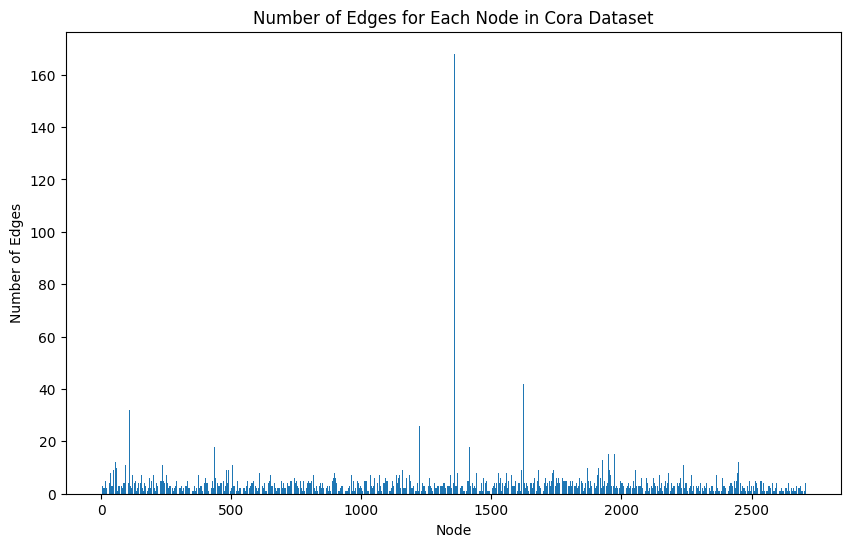

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora')

# Create the igraph graph
ig_graph = nx.Graph()
ig_graph.add_nodes_from(range(len(dataset.data.y)))
ig_graph.add_edges_from(dataset.data.edge_index.t().tolist())

# Get the number of edges for each node
num_edges_per_node = [ig_graph.degree(node) for node in ig_graph.nodes]

# Plot the graph between nodes and number of edges
plt.figure(figsize=(10, 6))
plt.bar(range(len(num_edges_per_node)), num_edges_per_node)
plt.xlabel("Node")
plt.ylabel("Number of Edges")
plt.title("Number of Edges for Each Node in Cora Dataset")
plt.show()


In [ ]:
import torch.nn as nn

class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate the GAT model
model = GATModel(in_channels=dataset.num_features, hidden_channels=8, out_channels=dataset.num_classes, heads=8)


In [ ]:
import torch.optim as optim

# Set up the training parameters
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.NLLLoss()

# Train the model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model for a few epochs
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}")


Epoch: 0, Loss: 1.9363
Epoch: 20, Loss: 0.4839
Epoch: 40, Loss: 0.3045
Epoch: 60, Loss: 0.3551
Epoch: 80, Loss: 0.2926
Epoch: 100, Loss: 0.3431
Epoch: 120, Loss: 0.2849
Epoch: 140, Loss: 0.2728
Epoch: 160, Loss: 0.2278
Epoch: 180, Loss: 0.2788


In [ ]:
# Validation function
def validate():
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)
        correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
        acc = correct / data.val_mask.sum().item()
    return acc

# Validate the model on the validation set
validation_accuracy = validate()
print(f"Validation Accuracy: {validation_accuracy:.4f}")


Validation Accuracy: 0.7933


In [ ]:
# Test function
def test():
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pred = logits.argmax(dim=1)
        correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        acc = correct / data.test_mask.sum().item()
    return acc

# Test the model on the test set
test_accuracy = test()
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8161


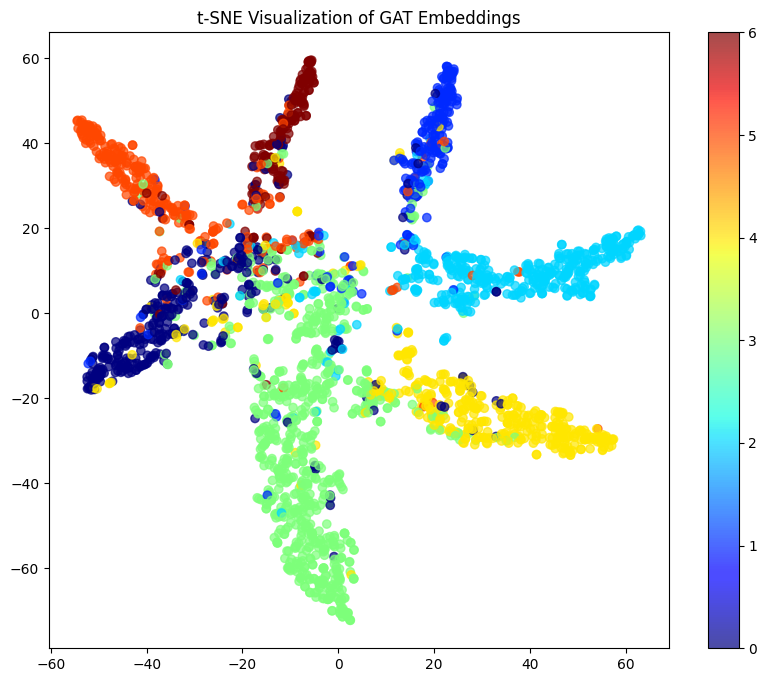

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Extract node embeddings from the trained GAT model
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu().numpy()

# Reduce the embeddings to 2D using t-SNE
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a scatter plot to visualize the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data.y, cmap='jet', alpha=0.7)
plt.colorbar()
plt.title('t-SNE Visualization of GAT Embeddings')
plt.show()

In [ ]:
!pip install python-igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.2 MB/s eta 0:00:00


In [ ]:
!pip install cairocffi